In [2]:
from gensim.models.keyedvectors import KeyedVectors
from nltk import word_tokenize
import numpy as np
#import preprocesamiento
import torch
print(torch.__version__)
#import torchvision.transforms as transforms
#from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
#from torchvision import datasets
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
#import utils
#from utils import EarlyStopping
from sklearn.metrics import balanced_accuracy_score
!pip install skorch
import skorch
from skorch import NeuralNetClassifier,NeuralNet
from sklearn.model_selection import RandomizedSearchCV,train_test_split,GridSearchCV
from mpl_toolkits import mplot3d
import scipy.interpolate as interp
from mpl_toolkits.mplot3d import Axes3D

1.3.1
     |████████████████████████████████| 112kB 2.8MB/s 


In [0]:
#/////////////////////////////////////////////////////////////

def generarDiccionario(dataset,wordvectors): #Recibo el dataset.values y los vectores
    
    token_idx = 0
    cant_patrones = dataset.shape[0]
    dataset = adaptarDataset(dataset) #esto pasa de vectores tipo ['holi' 'perri'] a [['holi'] ['perri']] que es lo que necesito
    wordSet = {} #diccionario de tokens. clave -> token valor -> indice de la posicion en el tensor de embeddings
    embeddingMat = [] #array (que luego sera convertido a tensor) de embeddings vocabulario propio
    promMat = np.zeros((300,cant_patrones),dtype=np.float32) #array de promedios de vectores de embeddings vocabulario original -> decision: no promediar embeddings no conocidos
    for i in range(cant_patrones):
        #print(dataset[i,0])
        words = word_tokenize(dataset[i,0])
        words_in_sentence = [] #lista de indices de las palabras que se encuentran en la oracion actual
        prom = np.zeros((300)) #acumulador de vectores de embeddings de las palabras de la oracion actual
        for w in words: #w is a token
            if w not in wordSet: #la palabra no se encuentra en el diccionario generado: se debe agregar
                wordSet[w] = token_idx
                if w in wordvectors:
                    words_in_sentence.append(token_idx)
                    s = wordvectors.get_vector(w)
                    embeddingMat.append(s) #Acá hay que meter al tensor en verdad. -> precision en los decimales
                    token_idx += 1
                else: #la palabra no esta en el vocabulario original, agregamos un vector de numeros aleatorios que luego sera entrenado
                    embeddingMat.append(np.random.normal(0,0.2,300))
                    token_idx+=1
            else: #la palabra ya se encuentra en el diccionario generado: debemos asignarle a la lista de indices el indice del token corresp
                words_in_sentence.append(wordSet[w])
        for indx in words_in_sentence: #promediamos solo los vectores de embedding encontrados en el vocabulario original
            prom += embeddingMat[indx] #Calcular promedio con embeddingMat y los indices de words_in_sentence
        cant_palabras = len(words_in_sentence)
        if len(words_in_sentence)>0:
            promMat[:,i] = prom/cant_palabras

    tensorEmbedding = torch.Tensor(embeddingMat)
    promMat = np.transpose(promMat)
    X = torch.from_numpy(promMat)
    X = X.float()
    return X,tensorEmbedding,wordSet

#/////////////////////////////////////////////////////////////

def adaptarDataset(dataset):
    cant_patrones = dataset.shape[0]
    aux= np.zeros((cant_patrones,1),dtype=object)
    for i in range(cant_patrones):
        aux[i] = dataset[i,1]
    return aux

#/////////////////////////////////////////////////////////////

def contarClase(dataset,clase): #metodo que cuenta la cantidad de patrones en 'dataset' que pertenecen a la clase 'clase'
    contador = 0
    for i in range(dataset.shape[0]):
        if dataset[i,0]==clase:
            contador+=1
    return contador

#/////////////////////////////////////////////////////////////

def separate_dataset(correctedData,validation=True):
    #Separo el dataset en test y train -> un patron de cada clase al subconjunto de test, el resto a train
    cantidad_preg = correctedData.shape[0]
    clase_actual = -1
    indxTest = [] #lista de indices de preguntas en subconjunto de test
    indxTrain= [] #lista de indices de preguntas en subconjunto de train
    indxVal = []
    #Xval = None
    #Yval = None
    
    for i in range(cantidad_preg):
        if correctedData[i,0]!=clase_actual: #cambio de clase
            clase_actual = correctedData[i,0]
            cantidadPregClase = contarClase(correctedData,clase_actual) #cuento cuantas preguntas hay pertenecientes a la clase actual
            if clase_actual!=46 and clase_actual !=103 and clase_actual!=104 and clase_actual !=105: #clases con solo 1 patron no se incluyen en test
                indxTest.append(np.random.randint(0, cantidadPregClase-1)+i) #tomo un indice al azar por clase y lo agrego al subconjunto de test
                if validation:
                    insertIndx = True
                    while insertIndx:
                        j = np.random.randint(0, cantidadPregClase-1)+i
                        if j not in indxTest:
                            indxVal.append(j)
                            insertIndx = False

    #Obtengo los indices de train
    indices = range(cantidad_preg)
    indxTrain = list(filter(lambda x: x not in indxTest and x not in indxVal, indices)) #al no meter clases con un solo patron al indxTest, pasan automaticamente al indxTrain
    return indxTrain, indxTest,indxVal

#/////////////////////////////////////////////////////////////

def FindMaxLength(lst): 
    maxLength = max(len(x) for x in lst ) 
  
    return maxLength

#/////////////////////////////////////////////////////////////

def embeddear(indx, dataset, wordSet, tensorEmbedding):
    cant_patrones = len(indx)
    tensores = []
    prom_tensor = np.zeros((cant_patrones,300))
    dataset = adaptarDataset(dataset) #esto pasa de vectores tipo ['holi' 'perri'] a [['holi'] ['perri']] que es lo que necesito
    for i in range(cant_patrones):
        words = word_tokenize(dataset[indx[i],0]) #Tengo las palabras de una oración
        cant_palabras = len(words)
        prom = 0
        tensores_locales = []
        for w in words:
            tensor = tensorEmbedding[wordSet[w]]
            tensores_locales.append(tensor)
            prom += tensor
        prom_tensor[i] = prom/cant_palabras
        tensores.append(tensores_locales)
    maxlen = FindMaxLength(tensores)
    return tensores, prom_tensor, maxlen

#/////////////////////////////////////////////////////////////

def longest(l):
    if(not isinstance(l, list)): return(0)
    return(max([len(l),] + [len(subl) for subl in l if isinstance(subl, list)] +
        [longest(subl) for subl in l]))

#/////////////////////////////////////////////////////////////

def formatearTensores(tensores,maxlen,sizeTensor=300):
    #Necesito meter todo en un array de cant_patrones * maxlen * 300
    #maxlen = longest(tensores)
    print("Longitud maxima para hardcodear: ",maxlen)
    cant_patrones = len(tensores)
    
    #Inicializo....
    tensorMatrix = np.zeros((cant_patrones, maxlen, sizeTensor), dtype=np.float32)
    
    #Armo la matriz necesaria de patrones*maxlen*300
    for i in range(cant_patrones):
        for j in range(len(tensores[i])):
            tensorMatrix[i][j] = tensores[i][j]
        #print(tensorMatrix[i])
    tensorMatrix = torch.from_numpy(tensorMatrix)
    return tensorMatrix 


#/////////////////////////////////////////////////////////////

def getLabels(indxTrain, indxTest, indxVal, dataset):
    Ytrain = []
    Ytest = []
    Yval = []
    for i in range(dataset.shape[0]):
        if i in indxTrain:
            Ytrain.append(dataset[i][0])
        if i in indxTest:
            Ytest.append(dataset[i][0])
        if i in indxVal:
            Yval.append(dataset[i][0])

    #Convirtiendo formatos de labels a tensores...

    Ytrain = torch.FloatTensor(Ytrain)
    Ytest = torch.FloatTensor(Ytest)
    Yval = torch.FloatTensor(Yval)

    return Ytrain, Ytest, Yval

#/////////////////////////////////////////////////////////////

In [0]:
class CNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size,maxlen,num_layers):
        super(CNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers

        if num_layers == 2:
            self.block=nn.Sequential(nn.Conv1d(input_size,hidden_size,3,padding=1),nn.ReLU(),nn.BatchNorm1d(hidden_size),nn.AvgPool1d(2),
            nn.Conv1d(hidden_size,hidden_size,3,padding=1),nn.ReLU(),nn.BatchNorm1d(hidden_size),nn.AvgPool1d(2))
        elif num_layers == 3:
            self.block=nn.Sequential(nn.Conv1d(input_size,hidden_size,3,padding=1),nn.ReLU(),nn.BatchNorm1d(hidden_size),nn.AvgPool1d(2),
            nn.Conv1d(hidden_size,hidden_size,3,padding=1),nn.ReLU(),nn.BatchNorm1d(hidden_size),nn.AvgPool1d(2),
            nn.Conv1d(hidden_size,hidden_size,3,padding=1),nn.ReLU(),nn.BatchNorm1d(hidden_size),nn.AvgPool1d(2))
        elif num_layers == 4:
            self.block=nn.Sequential(nn.Conv1d(input_size,hidden_size,3,padding=1),nn.ReLU(),nn.BatchNorm1d(hidden_size),nn.AvgPool1d(2),
            nn.Conv1d(hidden_size,hidden_size,3,padding=1),nn.ReLU(),nn.BatchNorm1d(hidden_size),nn.AvgPool1d(2),
            nn.Conv1d(hidden_size,hidden_size,3,padding=1),nn.ReLU(),nn.BatchNorm1d(hidden_size),nn.AvgPool1d(2),
            nn.Conv1d(hidden_size,hidden_size,3,padding=1),nn.ReLU(),nn.BatchNorm1d(hidden_size),nn.AvgPool1d(2))
        self.out = nn.Linear(hidden_size*int(maxlen/2**num_layers),output_size)

    def forward(self, inputs, hidden=None):
        # Turn (seq_len x batch_size x input_size) into (batch_size x input_size x seq_len) for CNN
        #inputs = inputs.transpose(0, 1).transpose(1, 2)

        #entra un tensor de dimensiones: batch x seq_len x input_size
        #quiero un tensor dedimensiones: batch x input_size x seq_len
        inputs = inputs.transpose(1, 2)
        x = self.block(inputs)
    
        p = torch.flatten(x,start_dim=1)
        output = self.out(p)

        return output

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [7]:
path_vectors = 'drive/My Drive/fasttext-sbwc.3.6.e20.vec'
path_dataset = "preprocessedQuestions_lem_completadas.csv"
wordvectors = KeyedVectors.load_word2vec_format(path_vectors)
dataset = pd.read_csv(path_dataset,delimiter=',',header=None)
cant_preg = dataset.values.shape[0]
cantidad_labels = dataset.values[len(dataset.values)-1,0] + 1

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [9]:
import nltk
nltk.download('punkt')
_,tensorEmbedding,wordSet = generarDiccionario(dataset.values,wordvectors)
print(tensorEmbedding.shape)

tensores,prom_tensor,maxlen = embeddear(range(cant_preg),dataset.values,wordSet,tensorEmbedding)

X = formatearTensores(tensores,maxlen)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
torch.Size([696, 300])
Longitud maxima para hardcodear:  22


In [10]:
Y = [x[0] for x in dataset.values]
from collections import Counter
count = Counter(Y)
print("clase y cantidad de patrones: ",sorted(count.items(), key=lambda pair: pair[1], reverse=True))
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    #device = torch.device("cuda")
    device = 'cuda'
    print("GPU is available")
else:
    device = 'cpu'
    #device = torch.device("cpu")
    print("GPU not available, CPU used")


clase y cantidad de patrones:  [(35, 27), (9, 26), (24, 25), (30, 25), (36, 22), (88, 22), (86, 20), (61, 19), (62, 19), (100, 19), (18, 18), (44, 18), (101, 18), (13, 17), (28, 17), (56, 17), (64, 17), (80, 17), (83, 17), (85, 17), (0, 16), (7, 16), (16, 16), (19, 16), (40, 16), (60, 16), (70, 16), (75, 16), (91, 16), (92, 16), (6, 15), (32, 15), (34, 15), (58, 15), (59, 15), (68, 15), (82, 15), (90, 15), (98, 15), (1, 14), (3, 14), (4, 14), (5, 14), (8, 14), (17, 14), (20, 14), (22, 14), (25, 14), (27, 14), (29, 14), (31, 14), (37, 14), (39, 14), (41, 14), (52, 14), (54, 14), (63, 14), (67, 14), (71, 14), (93, 14), (94, 14), (10, 13), (12, 13), (50, 13), (53, 13), (55, 13), (57, 13), (65, 13), (66, 13), (69, 13), (72, 13), (74, 13), (77, 13), (81, 13), (84, 13), (2, 12), (11, 12), (15, 12), (26, 12), (33, 12), (38, 12), (49, 12), (78, 12), (79, 12), (87, 12), (89, 12), (99, 12), (14, 11), (21, 11), (42, 11), (43, 11), (45, 11), (47, 11), (48, 11), (73, 11), (76, 11), (97, 11), (102, 

In [12]:
dict_size = len(X[0][0])
print("Dict_size: ",dict_size)
print("cantidad d labels: ",cantidad_labels)

n_epochs = 500
batch_size = 500
hidden_size = 20
num_layers=3
model = CNN(input_size=dict_size,hidden_size = hidden_size,output_size=cantidad_labels,maxlen=maxlen,num_layers=num_layers)

# We'll also set the model to the device that we defined earlier (default is CPU)
model = model.to(device)

parameters = {    
    #'module__hidden_dim' : [12,24,48,96],
    'module__hidden_size' : [12,24,36,48,96],    
    #'max_epochs' : [50,70,90,110,130,150]
    'module__num_layers':[2,3,4],
    'max_epochs' : [60,90,120,150,200],
    'batch_size' : [1500,1000,750,300]
}

Dict_size:  300
cantidad d labels:  106


In [17]:
candidatos = 30
net = NeuralNetClassifier(model,module__input_size = dict_size,module__hidden_size=hidden_size,module__output_size=cantidad_labels,module__maxlen=maxlen,module__num_layers=num_layers,criterion=torch.nn.CrossEntropyLoss,optimizer=torch.optim.Adam,verbose=1,device=device)
gs = RandomizedSearchCV(net,parameters,verbose=2,n_jobs=-1,cv=10,scoring='balanced_accuracy',n_iter=candidatos)
print(type(X))
X_numpy = X.numpy()
print(type(Y))
Y_numpy = np.asarray(Y)
X_train,X_test,y_train,y_test = train_test_split(X_numpy,Y_numpy,shuffle=True,stratify=Y_numpy,test_size=0.1,random_state=12)
#y_train_tensor = torch.LongTensor(y_train)
y_test_tensor = torch.LongTensor(y_test)
print(type(X_train))
print(type(y_train_tensor))
gs.fit(X_train,y_train)


<class 'torch.Tensor'>
<class 'list'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
Fitting 10 folds for each of 30 candidates, totalling 300 fits


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 9 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 15.4min


Re-initializing module because the following parameters were re-set: hidden_size, input_size, maxlen, num_layers, output_size.
Re-initializing module because the following parameters were re-set: hidden_size, input_size, maxlen, num_layers, output_size.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        4.7856       0.0285        4.6331  0.0587
      2        4.3548       0.0601        4.5527  0.0646


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 33.0min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


      3        3.9822       0.0854        4.4414  0.0495
      4        3.5834       0.0854        4.3752  0.0499
      5        3.0785       0.0696        4.2684  0.0491
      6        2.6060       0.0949        4.0903  0.0501
      7        2.1795       0.1234        3.8586  0.0527
      8        1.7793       0.1582        3.5742  0.0506
      9        1.4326       0.2152        3.2817  0.0582
     10        1.1430       0.2658        2.9779  0.0529
     11        0.8942       0.3291        2.7006  0.0505
     12        0.6836       0.3797        2.4817  0.0498
     13        0.5186       0.3861        2.3799  0.0502
     14        0.3816       0.4304        2.1673  0.0501
     15        0.2809       0.4589        2.0607  0.0493
     16        0.1927       0.4684        1.9762  0.0497
     17        0.1333       0.5032        1.9008  0.0517
     18        0.0979       0.4968        1.8537  0.0495
     19        0.0696       0.5127        1.8388  0.0501
     20        0.0538       0.5

RandomizedSearchCV(cv=10, error_score='raise-deprecating',
                   estimator=<class 'skorch.classifier.NeuralNetClassifier'>[uninitialized](
  module=CNN(
    (block): Sequential(
      (0): Conv1d(300, 20, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): ReLU()
      (2): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): AvgPool1d(kernel_size=(2,), stride=(2,)...
  module__num_layers=3,
  module__output_size=106,
),
                   iid='warn', n_iter=30, n_jobs=-1,
                   param_distributions={'batch_size': [1500, 1000, 750, 300],
                                        'max_epochs': [60, 90, 120, 150, 200],
                                        'module__hidden_size': [12, 24, 36, 48,
                                                                96],
                                        'module__num_layers': [2, 3, 4]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
            

In [18]:
hidden_size = []
max_epochs = []
batch_size = []
num_layers = []
score = []
std = []

# Utility function to report best scores (found online)
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        print(i)
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
            batch_size.append(results['params'][candidate]['batch_size'])
            hidden_size.append(results['params'][candidate]['module__hidden_size'])
            max_epochs.append(results['params'][candidate]['max_epochs'])
            num_layers.append(results['params'][candidate]['module__num_layers'])
            score.append(results['mean_test_score'][candidate])
            std.append(results['std_test_score'][candidate])

report(gs.cv_results_,candidatos)

1
Model with rank: 1
Mean validation score: 0.661 (std: 0.038)
Parameters: {'module__num_layers': 3, 'module__hidden_size': 96, 'max_epochs': 200, 'batch_size': 1000}

2
Model with rank: 2
Mean validation score: 0.642 (std: 0.041)
Parameters: {'module__num_layers': 2, 'module__hidden_size': 48, 'max_epochs': 150, 'batch_size': 1000}

3
Model with rank: 3
Mean validation score: 0.633 (std: 0.036)
Parameters: {'module__num_layers': 4, 'module__hidden_size': 96, 'max_epochs': 60, 'batch_size': 1000}

4
Model with rank: 4
Mean validation score: 0.629 (std: 0.033)
Parameters: {'module__num_layers': 2, 'module__hidden_size': 96, 'max_epochs': 200, 'batch_size': 750}

5
Model with rank: 5
Mean validation score: 0.626 (std: 0.037)
Parameters: {'module__num_layers': 2, 'module__hidden_size': 48, 'max_epochs': 90, 'batch_size': 1000}

6
Model with rank: 6
Mean validation score: 0.625 (std: 0.027)
Parameters: {'module__num_layers': 3, 'module__hidden_size': 48, 'max_epochs': 120, 'batch_size': 15

In [19]:
probs = gs.best_estimator_.predict_proba(X_test)
acc = balanced_accuracy_score(y_test_tensor,np.argmax(probs,axis=1))
print("tasa de acierto obtenida: ",acc)

tasa de acierto obtenida:  0.6462264150943396


In [20]:
print("hidden_size=",hidden_size)
print("max_epochs=",max_epochs)
print("batch_size=",batch_size)
print("num_layers=",num_layers)
print("score=",score)
print("std=",std)


hidden_size= [96, 48, 96, 96, 48, 48, 96, 36, 48, 36, 48, 48, 36, 36, 24, 24, 36, 24, 36, 36, 12, 12, 24, 12, 12, 12, 12, 12, 12, 12]
max_epochs= [200, 150, 60, 200, 90, 120, 200, 120, 60, 200, 90, 120, 120, 150, 200, 60, 200, 200, 150, 90, 150, 200, 200, 120, 60, 90, 200, 120, 90, 120]
batch_size= [1000, 1000, 1000, 750, 1000, 1500, 300, 1000, 300, 1500, 1000, 1500, 1500, 300, 1000, 300, 300, 300, 1000, 300, 1500, 300, 1500, 1500, 1500, 1000, 1000, 300, 1000, 1000]
num_layers= [3, 2, 4, 2, 2, 3, 2, 2, 2, 3, 4, 4, 3, 3, 2, 2, 3, 2, 4, 4, 2, 2, 4, 2, 3, 3, 3, 3, 4, 4]
score= [0.6607917740714148, 0.6417081759511638, 0.6327722130020885, 0.6286802532388639, 0.6259549657659335, 0.6251071945627555, 0.6239242243270657, 0.6186004612495626, 0.5962962853977931, 0.5919004675831497, 0.5885614153381548, 0.5876207655345239, 0.5859066100417811, 0.5762357688124823, 0.5699499637266677, 0.5694059338052322, 0.5620521065529834, 0.5543749207133898, 0.538941052238643, 0.5125034400346611, 0.46919020416383844

tasa de acierto obtenida:  0.6462264150943396


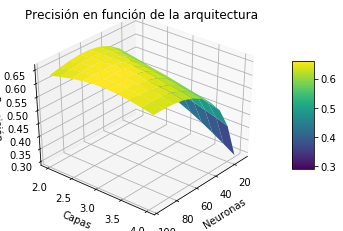

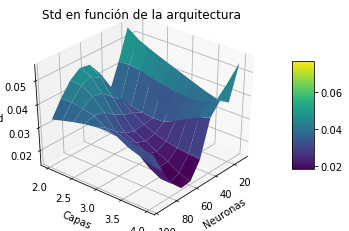

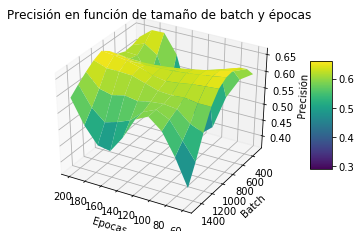

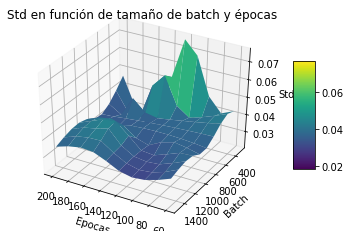

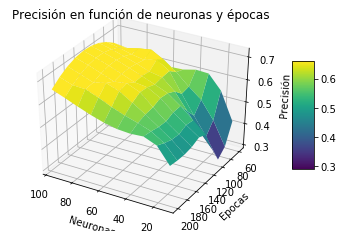

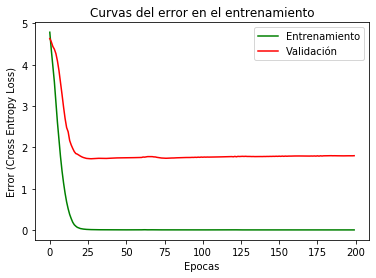

In [21]:
hidden_dim = hidden_size
ejex = hidden_dim
ejey = num_layers
ejez = score

plotx,ploty, = np.meshgrid(np.linspace(np.min(ejex),np.max(ejex),10),\
                           np.linspace(np.min(ejey),np.max(ejey),10))
plotz = interp.griddata((ejex,ejey),ejez,(plotx,ploty),method='cubic')
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(35,40)
ax.set_xlabel('Neuronas')
ax.set_ylabel('Capas')
ax.set_zlabel('Precisión')
ax.set_title('Precisión en función de la arquitectura')

surf = ax.plot_surface(plotx,ploty,plotz,vmin=np.nanmin(ejez),vmax = np.nanmax(ejez),cstride=1,rstride=1,cmap='viridis')
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.savefig("prueba6_Neuronas_Capas_Precision.svg")
#/////////////////////////////
#////////////////////////////

ejex = hidden_dim
ejey = num_layers
ejez = std

plotx,ploty, = np.meshgrid(np.linspace(np.min(ejex),np.max(ejex),10),\
                           np.linspace(np.min(ejey),np.max(ejey),10))
plotz = interp.griddata((ejex,ejey),ejez,(plotx,ploty),method='cubic')
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(35,40)
ax.set_xlabel('Neuronas')
ax.set_ylabel('Capas')
ax.set_zlabel('Std')
ax.set_title('Std en función de la arquitectura')

surf = ax.plot_surface(plotx,ploty,plotz,vmin=np.nanmin(ejez),vmax = np.nanmax(ejez),cstride=1,rstride=1,cmap='viridis')
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.savefig("prueba6_Neuronas_Capas_STD.svg")
#/////////////////////////////
#////////////////////////////

ejex = max_epochs
ejey = batch_size
ejez = score

plotx,ploty, = np.meshgrid(np.linspace(np.min(ejex),np.max(ejex),10),\
                           np.linspace(np.min(ejey),np.max(ejey),10))
plotz = interp.griddata((ejex,ejey),ejez,(plotx,ploty),method='cubic')
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(35,120)
ax.set_xlabel('Epocas')
ax.set_ylabel('Batch')
ax.set_zlabel('Precisión')
ax.set_title('Precisión en función de tamaño de batch y épocas')

surf = ax.plot_surface(plotx,ploty,plotz,vmin=np.nanmin(ejez),vmax = np.nanmax(ejez),cstride=1,rstride=1,cmap='viridis')
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.savefig("prueba6_Epocas_Batch_Precision.svg")

#/////////////////////////////
#////////////////////////////

ejex = max_epochs
ejey = batch_size
ejez = std

plotx,ploty, = np.meshgrid(np.linspace(np.min(ejex),np.max(ejex),10),\
                           np.linspace(np.min(ejey),np.max(ejey),10))
plotz = interp.griddata((ejex,ejey),ejez,(plotx,ploty),method='cubic')
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(35,120)
ax.set_xlabel('Epocas')
ax.set_ylabel('Batch')
ax.set_zlabel('Std')
ax.set_title('Std en función de tamaño de batch y épocas')

surf = ax.plot_surface(plotx,ploty,plotz,vmin=np.nanmin(ejez),vmax = np.nanmax(ejez),cstride=1,rstride=1,cmap='viridis')
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.savefig("prueba6_Epocas_Batch_STD.svg")

#/////////////////////////////
#////////////////////////////

ejex = hidden_dim
ejey = max_epochs
ejez = score

plotx,ploty, = np.meshgrid(np.linspace(np.min(ejex),np.max(ejex),10),\
                           np.linspace(np.min(ejey),np.max(ejey),10))
plotz = interp.griddata((ejex,ejey),ejez,(plotx,ploty),method='cubic')
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(35,120)
ax.set_xlabel('Neuronas')
ax.set_ylabel('Epocas')
ax.set_zlabel('Precisión')
ax.set_title('Precisión en función de neuronas y épocas')

surf = ax.plot_surface(plotx,ploty,plotz,vmin=np.nanmin(ejez),vmax = np.nanmax(ejez),cstride=1,rstride=1,cmap='viridis')
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.savefig("prueba6_Neuronas_Epocas_Precision.svg")

# get training and validation loss
epochs = [i for i in range(len(gs.best_estimator_.history))]
train_loss = gs.best_estimator_.history[:,'train_loss']
valid_loss = gs.best_estimator_.history[:,'valid_loss']
acc = balanced_accuracy_score(y_test_tensor,np.argmax(probs,axis=1))
print("tasa de acierto obtenida: ",acc)
fig1 = plt.figure()
plt.plot(epochs,train_loss,'g-')
plt.plot(epochs,valid_loss,'r-')
plt.title('Curvas del error en el entrenamiento')
plt.xlabel('Epocas')
plt.ylabel('Error (Cross Entropy Loss)')
plt.legend(['Entrenamiento','Validación'])
plt.savefig("prueba6_Loss.svg")
plt.show()
